In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import scipy.signal as ss
from scipy.io import wavfile
import operator
from mpl_toolkits import mplot3d


class MicArray:

    def __init__(self,device_index = None,rate = 16000,channels = 4,chunk_size = 1024):
        self.p = pyaudio.PyAudio()
        self.q = queue.Queue()
        self.thread_event = threading.Event()

        self.rate = rate
        self.channels = channels
        self.chunk_size = chunk_size
        
        if device_index == None:
            for i in range(self.p.get_device_count()):
                dev = self.p.get_device_info_by_index(i)
                name = dev['name'].encode('utf-8')
                print(i, name, dev['maxInputChannels'], dev['maxOutputChannels'])
                if dev['maxInputChannels'] == self.channels:
                    print('Use {}'.format(name))
                    device_index = i
                    break

                
        self.stream = self.p.open(
            input_device_index = device_index,
            start = False,
            format=pyaudio.paInt16,
            channels=self.channels,
            rate=self.rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._callback
        )
               
    def _callback(self,input_data,frame_count,time_info,status_flag):
        self.q.put(input_data)
        return (None,pyaudio.paContinue)
    
    def start(self):
        self.q.queue.clear()
        self.stream.start_stream()
    
    def stop(self):
        self.thread_event.set()
        self.stream.stop_stream()
        self.q.put('')

    def read_mic_data(self):
        self.thread_event.clear()
        while not self.thread_event.is_set():
            frames = self.q.get()
            if not frames:
                break
            
            frames = np.frombuffer(frames,dtype = 'int16')
            yield frames

    def __enter__(self):
        self.start()
        return self

    def __exit__(self,exception_type,exception_value,traceback):
        if exception_value:
            return False
        self.stop()

def array_response_vector(theta,phi,gamma):
    v = np.exp((1j*2*np.pi)/lamda*r*np.sin(theta)*np.cos(phi-gamma))
    return v


def music(CovMat,L,N,Phi,Theta):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    D,V = LA.eig(CovMat)
    idx = D.argsort()
    lmbd = D[idx]
    V = V[:, idx]
    Qn  = V[:,L:N]
    
    gamma = np.zeros(N)
    for i in range(N):
        gamma[i] = (2*np.pi/N)*i
    
    print(gamma)
    numTheta = Theta.size
    numPhi   = Phi.size
    pspectrum = np.zeros((numTheta,numPhi))
    
    for i in range(numTheta):
        for ii in range(numPhi):
            av = array_response_vector(Theta[i],Phi[ii],gamma)
            pspectrum[i][ii] = 1/LA.norm((av.conj().transpose()@Qn@Qn.conj().transpose()@av))
            
       
    print(pspectrum.max())   
    #psindB    = np.log10(10*pspectrum/pspectrum.min())
    #print(psindB.shape)
    #DoAsMUSIC,_= ss.find_peaks(psindB,height=0, distance=1.2)
    #print(DoAsMUSIC)
    return pspectrum




#=====================================================================================================>

r = 0.07071                      #radius
N = 4                      #number of elements
d = 2*r*np.sin(np.pi/N)    #Inter element spacing
L = 3                      #Number of sources
speed = 343.2


Theta = np.linspace(0,np.pi,180)
Phi   = np.linspace(0,np.pi,180)

x = np.arange(0,220160,1)
fs1, data1 = wavfile.read('./2d_4.wav')

lamda = speed/fs1
#data1 = filteredData

data_extracted = np.take(data1, x)
data_extracted = np.fft.fft(data_extracted)
#data_extracted = np.fft.ifft(data_extracted)

data1 = data_extracted[0::4]
data2 = data_extracted[1::4]
data3 = data_extracted[2::4]
data4 = data_extracted[3::4]

x = np.asmatrix([data1,data2,data3,data4])
CovMat = x@x.conj().transpose()

spectrum = music(CovMat,L,N,Phi,Theta)
xmax, ymax = np.unravel_index(np.argmax(spectrum), spectrum.shape)

print(xmax , ymax)
print((xmax*np.pi)/180, (ymax*np.pi)/180)

[0.         1.57079633 3.14159265 4.71238898]
28152.772023098776
28 160
0.4886921905584123 2.792526803190927


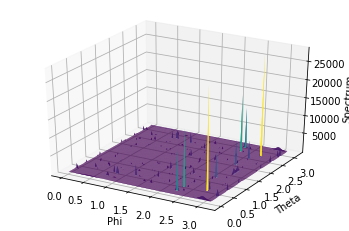

In [22]:
%matplotlib inline
Theta, Phi = np.meshgrid(Theta,Phi)
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_surface(Theta, Phi, spectrum, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel("Phi")
ax.set_ylabel("Theta")
ax.set_zlabel("Spectrum")
plt.show()